# Introduction

城市作为人类空间活动的载体，有着丰富的空间形态与结构机理，众多研究者对这一命题展开了丰富的研究，

然而现有研究多从建筑学及设计学的角度出发，很少有研究从数据科学的角度对城市街道的形态与结构进行分析。

（好了我编不下去了。。。。。

### 本篇教程的主要目的在于介绍给大家利用osmnx以及geopandas采集openstreetmap上的城市街道数据，计算并可视化街道的*方向熵( orientation entropy)*

具体的方法大家可以关注osmnx的github主页：https://github.com/gboeing/osmnx

也可以读一下Geoff Boeing 2019年发表在Applied Network Science上的文章  
***Urban spatial order: street network orientation, configuration, and entropy***

DOI: https://doi.org/10.1007/s41109-019-0189-1   

本教程实际上是对这篇文章的一个小点的复现

PS：这里的方向熵是指一个区域内所有街道的方向的混乱程度。举个例子，大家都知道北京、西安这种皇城，道路一般都十分规整（体现了权威与秩序），属于棋盘格式的布局，路痴也不容易迷路，反正就东南西北四个方向，对应的方向熵就会很低（不混乱）；反观重庆之类的城市，城市形态十分diversity，各种路纵横交错，路痴肯定迷路，对应的方向熵就会很高（很混乱）

------------
言归正传我们开始分析

首先调包，此处为小旭学长的开发的**plot_map**打call，强烈推荐！超好用！！！

In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from plot_map import plot_map
import math

下面是四个计算街道方向熵以及绘图的函数，大家不用理解，直接拿来用即可

其中方向熵的计算公式为：

$H = -\sum_{i=1}^{n}P(o_i)log_eP(o_i)$

其实就是香农熵的计算公式，$P(o_i)$指方向为第i个方向的街道的比例（这里将街道的方向分为了36类，将正北设置为0度，以10度为间隔创建36个区间，街道的方向落在哪个区间，我们就认为它的方向就在这个区间）

In [2]:
def reverse_bearing(x):
    return x + 180 if x < 180 else x - 180

In [3]:
def count_and_merge(n, bearings):
    # make twice as many bins as desired, then merge them in pairs
    # prevents bin-edge effects around common values like 0° and 90°
    n = n * 2
    bins = np.arange(n + 1) * 360 / n
    count, _ = np.histogram(np.array(bearings), bins=bins)
    
    # move the last bin to the front, so eg 0.01° and 359.99° will be binned together
    count = np.roll(count, 1)
    return count[::2] + count[1::2]

In [4]:
def calculate_entropy(count):
    count_p = count/count.sum()
    entropy = 0
    for i in count_p:
        entropy -= i*math.log(i)
    return entropy 

In [5]:
# function to draw a polar histogram for a set of edge bearings
def polar_plot(ax, bearings, n=36, title=''):

    bins = np.arange(n + 1) * 360 / n
    count = count_and_merge(n, bearings)
    _, division = np.histogram(bearings, bins=bins)
    frequency = count / count.sum()
    division = division[0:-1]
    width =  2 * np.pi / n

    ax.set_theta_zero_location('N')
    ax.set_theta_direction('clockwise')

    x = division * np.pi / 180
    bars = ax.bar(x, height=frequency, width=width, align='center', bottom=0, zorder=2,
                  color='#003366', edgecolor='k', linewidth=0.5, alpha=0.7)
    
    ax.set_ylim(top=frequency.max())
    
    title_font = {'family':'DejaVu Sans', 'size':24, 'weight':'bold'}
    xtick_font = {'family':'DejaVu Sans', 'size':10, 'weight':'bold', 'alpha':1.0, 'zorder':3}
    ytick_font = {'family':'DejaVu Sans', 'size': 9, 'weight':'bold', 'alpha':0.2, 'zorder':3}
    
    ax.set_title(title.upper(), y=1.05, fontdict=title_font)
    
    ax.set_yticks(np.linspace(0, max(ax.get_ylim()), 5))
    yticklabels = ['{:.2f}'.format(y) for y in ax.get_yticks()]
    yticklabels[0] = ''
    ax.set_yticklabels(labels=yticklabels, fontdict=ytick_font)
    
    xticklabels = ['N', '', 'E', '', 'S', '', 'W', '']
    ax.set_xticklabels(labels=xticklabels, fontdict=xtick_font)
    ax.tick_params(axis='x', which='major', pad=-2)

首先导入上海市的shp地图

In [6]:
sh = gpd.read_file('./上海行政区/区县界_area.shp')

下面开始下载上海市各个区的路网数据，并计算每个区的路网的方向熵

In [7]:
### 创造一个空的GeoDataFrame，用来储存我们即将下载的各个区的路网数据
sh_road = gpd.GeoDataFrame(columns = ['u', 'v', 'key', 'osmid', 'name', 'highway', 'oneway', 'length',
       'geometry', 'bridge', 'ref', 'lanes', 'maxspeed', 'access', 'tunnel',
       'junction','district'])

### 创造一个空的列表，用来存放各个区内各个街道的方向
sh_orientation_count = []

### 写一个循环，遍历上海的每个区，依次获取并处理路网数据
for i in sh.index:
    
    ### 利用osmnx，获取每个区的路网数据（可以通行小汽车的路网）
    G = ox.graph_from_polygon(sh.loc[i,'geometry'],network_type='drive')
    #sh.loc[i,'三岔路口比例'] = ox.stats.basic_stats(G)['streets_per_node_proportion'][3]
    #sh.loc[i,'十字路口比例'] = ox.stats.basic_stats(G)['streets_per_node_proportion'][4]
    
    ### 上一步获取的路网数据格式为networkx中的graph格式，这里我们将它转换成GeoDataFrame
    road_gdf = ox.graph_to_gdfs(G)[1]
    
    ### 并为路网赋上相应的行政区信息（属于哪个区）
    road_gdf['district'] = sh.loc[i,'NAME']
    ### 将每个区的路网添加至总的路网数据中
    sh_road = sh_road.append(road_gdf,ignore_index=True)
    
    ### 利用osmnx的add_edge_bearings函数为路网的边添加方向属性
    Gu = ox.add_edge_bearings(ox.get_undirected(G))
    
    ### 将边的方向属性都提取出来，存在一个Series中
    b = pd.Series([d['bearing'] for u, v, k, d in Gu.edges(keys=True, data=True)])
    
### 为边添加另一个方向的方向属性（+-180度）（因为路都是直线，如果从a端点到b端点与正北的夹角为30度，那么b端点到a端点与正北的夹角就是210度
    b = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop=True).dropna()
    
    ### 将提取出来的方向属性添加到总的方向数据中
    sh_orientation_count.append(b)
    
    ### 计算每个区的街道的方向熵，并直接储存在上海的GeoDataFrame中
    sh.loc[i,'方向熵'] = calculate_entropy(count_and_merge(36,b))
    
    print('{}处理完毕'.format(sh.loc[i,'NAME']))

宝山区处理完毕
杨浦区处理完毕
闵行区处理完毕
普陀区处理完毕
松江区处理完毕
虹口区处理完毕
闸北区处理完毕
长宁区处理完毕
徐汇区处理完毕
静安区处理完毕
黄浦区处理完毕
金山区处理完毕
崇明县处理完毕
奉贤区处理完毕
嘉定区处理完毕
青浦区处理完毕
浦东新区处理完毕


经过上一步的操作，我们可以得到三个数据：
1. 上海的GeoDataFrame，储存了每个区的geometry和方向熵的具体数值
2. 上海的路网数据GeoDataFrame，储存了上海每个区的路网数据，有一个district字段专门来标记每条道路属于哪个区
3. 上海各个区的道路方向的集合（列表形式），储存了每个区内所有路网的方向

---------

下面我们开始可视化

首先我们从上海的GeoDataFrame中提取每个区的方向熵，然后根据区的名称的字段，将其与上海路网数据的GeoDataFrame进行连接

这样我们可以为路网数据的GeoDataFrame添加一个方向熵的字段，代表每条道路所在区的路网的方向熵

In [8]:
### 提取街道名称与方向熵字段
sh_district_entropy = sh.loc[:,['NAME','方向熵']]

In [9]:
### 为了与路网数据的GeoDataFrame统一，改一下表的名字，将街道名称字段的列名从NAME改为district，方便下面进行连接
sh_district_entropy.columns = ['district','方向熵']

In [10]:
### 根据district字段进行连接
sh_road = pd.merge(sh_road,sh_district_entropy,on='district',how='outer')

In [11]:
sh_bounds = [120.79560279980944,30.623112899720564,122.03020320013769, 31.925845100091397]

imgsavepath do not exist, your tile map will not save


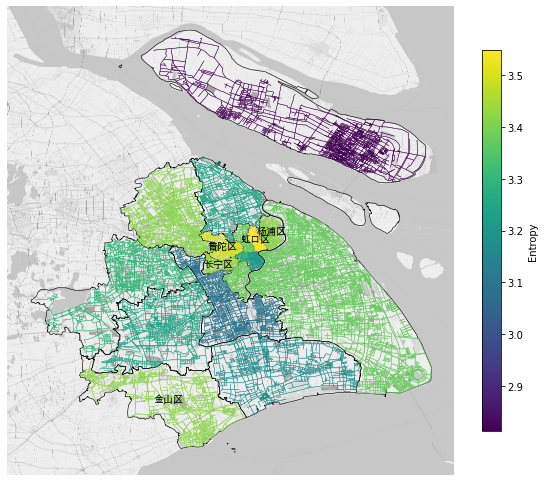

In [12]:
#### 开始绘图，先设置上海的行政区作为底图
base = sh.plot(figsize=(10,10),facecolor='none',edgecolor='black',lw=0.6)

### 然后在底图上绘制路网地图，并以每条道路所在区的方向熵大小为路网赋予颜色（cmap操作）
sh_road.plot(ax=base,column='方向熵',lw=0.4,legend=True,legend_kwds={'shrink':0.7,'label':'Entropy'})

### 标记方向熵大于75%分位数的区的名称
for i in sh.index:
    if sh.loc[i,'方向熵'] >= sh['方向熵'].quantile(0.75):
        plt.text(sh.loc[i,'geometry'].centroid.x,sh.loc[i,'geometry'].centroid.y,sh.loc[i,'NAME'],fontdict={'family':'Arial Unicode MS','size':10},horizontalalignment='center',verticalalignment='center')

### 调用plot_map添加osm的底图
plot_map(plt,sh_bounds,zoom=14,style=4)

### 关闭坐标轴，更好看
base.axis('off')

### 保存图片
plt.savefig('sh_entropy_plot.jpg',dpi=70,bbox_inches='tight')

plt.show()

这样上海市的路网情况就可视化出来了，可以看到，虹口区的路网方向熵最大，说明路网最乱，路痴最容易迷路；普陀区其次，杨浦、长宁与金山也处在前几位。


-------------



以上只是最简单的可视化，我们还可以做的骚一点，就是用一个类似罗盘的图把所有方向街道的占比给画出来，具体如下。

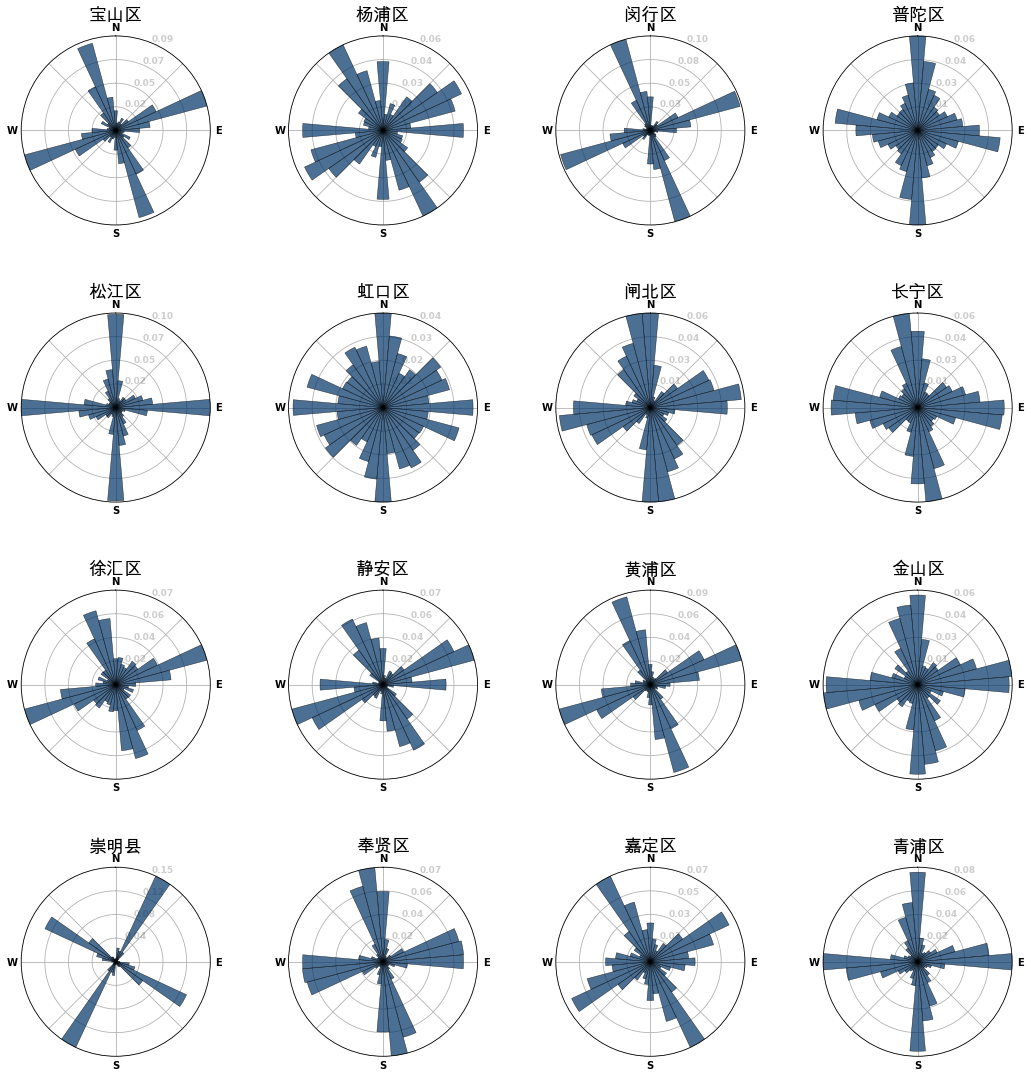

In [13]:
fig, axes = plt.subplots(4,4, figsize=(15,15),subplot_kw={'projection':'polar'})
fig.tight_layout(h_pad=5)
for i in range(4):
    for x in range(4):
        polar_plot(axes[i][x],sh_orientation_count[i*4+x])
        axes[i][x].set_title(sh.loc[i*4+x,'NAME'],fontdict={'family':'Arial Unicode MS','weight':'heavy','size':18})
plt.savefig('sh_street_orientation.jpg',dpi=70,bbox_inches='tight')
plt.show()

#### 可以看到，果不其然，虹口的道路各个方向的都有，难怪方向熵那么大，反观闵行，道路方向的分布十分集中，说明闵行的路网多为方格式布局，十分规整。

## 上海的可视化就到此为止，下面我们来可视化一下5D城市重庆的街道方向熵。
具体的代码跟上海一样，我就不加注释了。

In [14]:
cq = gpd.read_file('./重庆市/区县界_area.shp')

In [15]:
cq = cq.iloc[[13,14,15,26,31,32,33,34,35],:]

In [16]:
cq.reset_index(drop=True,inplace=True)

In [17]:
cq_road = gpd.GeoDataFrame(columns = ['u', 'v', 'key', 'osmid', 'name', 'highway', 'oneway', 'length',
       'geometry', 'bridge', 'ref', 'lanes', 'maxspeed', 'access', 'tunnel',
       'junction','district'])
cq_orientation_count = []
for i in cq.index:
    
    G = ox.graph_from_polygon(cq.loc[i,'geometry'],network_type='drive')
    #cq.loc[i,'三岔路口比例'] = ox.stats.basic_stats(G)['streets_per_node_proportion'][3]
    #cq.loc[i,'十字路口比例'] = ox.stats.basic_stats(G)['streets_per_node_proportion'][4]
    
    road_gdf = ox.graph_to_gdfs(G)[1]
    road_gdf['district'] = cq.loc[i,'NAME']
    cq_road = cq_road.append(road_gdf,ignore_index=True)
    
    Gu = ox.add_edge_bearings(ox.get_undirected(G))
    b = pd.Series([d['bearing'] for u, v, k, d in Gu.edges(keys=True, data=True)])
    b = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop=True).dropna()
    cq_orientation_count.append(b)
    
    cq.loc[i,'方向熵'] = calculate_entropy(count_and_merge(36,b))
    
    print('{}处理完毕'.format(cq.loc[i,'NAME']))

渝北区处理完毕
北碚区处理完毕
沙坪坝区处理完毕
巴南区处理完毕
江北区处理完毕
九龙坡区处理完毕
南岸区处理完毕
渝中区处理完毕
大渡口区处理完毕


In [18]:
cq_district_entropy = cq.loc[:,['NAME','方向熵']]

In [19]:
cq_district_entropy.columns = ['district','方向熵']

In [20]:
cq_road = pd.merge(cq_road,cq_district_entropy,on='district',how='outer')

In [21]:
cq_bounds = [106.20977790026993,29.079847999725487,107.03557209963279, 30.17672399987273]

imgsavepath do not exist, your tile map will not save


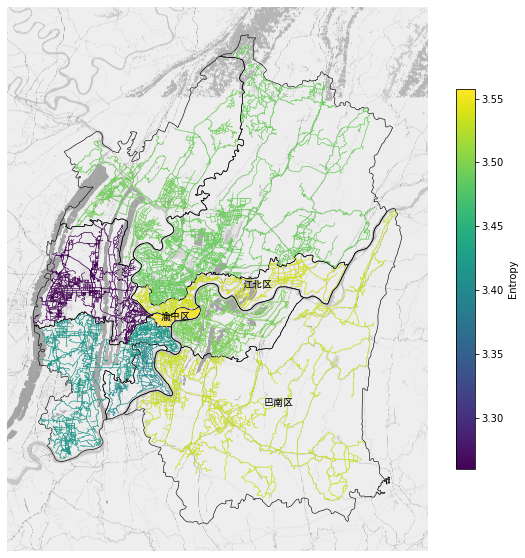

In [22]:
base = cq.plot(figsize=(10,10),facecolor='none',edgecolor='black',lw=0.6)
cq_road.plot(ax=base,column='方向熵',lw=0.4,legend=True,legend_kwds={'shrink':0.7,'label':'Entropy'})
for i in cq.index:
    if cq.loc[i,'方向熵'] >= cq['方向熵'].quantile(0.75):
        plt.text(cq.loc[i,'geometry'].centroid.x,cq.loc[i,'geometry'].centroid.y,cq.loc[i,'NAME'],fontdict={'family':'Arial Unicode MS','size':10},horizontalalignment='center',verticalalignment='center')
plot_map(plt,cq_bounds,zoom=14,style=4)
base.axis('off')
plt.savefig('cq_entropy_plot.jpg',dpi=70,bbox_inches='tight')
plt.show()

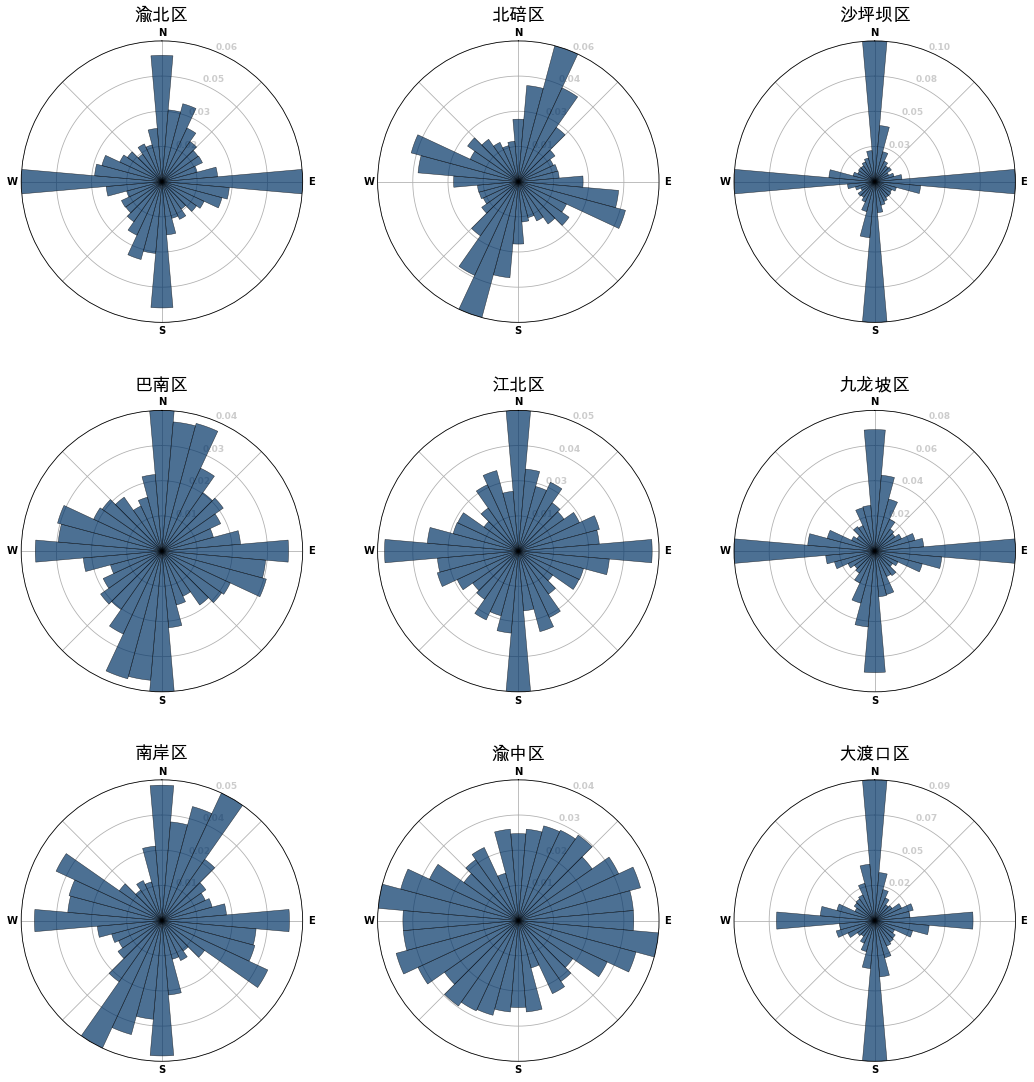

In [23]:
fig, axes = plt.subplots(3,3, figsize=(15,15),subplot_kw={'projection':'polar'})
fig.tight_layout(h_pad=5)
for i in range(3):
    for x in range(3):
        polar_plot(axes[i][x],cq_orientation_count[i*3+x])
        axes[i][x].set_title(cq.loc[i*3+x,'NAME'],fontdict={'family':'Arial Unicode MS','weight':'heavy','size':18})
plt.savefig('cq_street_orientation.jpg',dpi=70,bbox_inches='tight')

### 哈哈哈哈哈哈哈，可以看到，渝中区太魔鬼了，路痴的噩梦，这谁能顶得住。

本篇教程到这里就结束啦，关于更多的信息，请欢迎大家关注我的公众号【Yuan的数据分析】以及github主页：https://github.com/YuanLianggg

还有小旭学长的python教程：https://github.com/ni1o1/pygeo-tutorial （强烈推荐！！！）